# Improving Performances

We will optimize two hyperparameters.

For our data agumentation, we are going to use the `RandAugment` [auto-augmentation policy](https://pytorch.org/vision/main/generated/torchvision.transforms.RandAugment.html) which only takes one parameter, called `magnitude`. This parameter will be one of the parameters we will optimize in our hyperparameter search.

We will also optimize the learning rate for the gradient descent. 

When doing hyperparameter optimization, it is important to have high-level functions (or scripts) that receive our hyperparameters as inputs, so we can run as many training runs as we need by only varying the calling to the function (or the script).

In [1]:
! pip install -q -r requirements.txt

In [2]:
# Let's also make sure that the GPU is active (otherwise things will be _very_ slow):

import torch
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Data Augmentation

Here we write two functions that create appropriate transforms for the training, validation and test dataset, and then create the relative dataloaders.

In [3]:
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import random
import multiprocessing
from helpers import get_train_val_data_loaders, get_test_data_loader
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

# Let's write a function that gives us the transforms so we can optimize the hyperparameters
def get_transforms(rand_augment_magnitude):

    # These are the per-channel mean and std of CIFAR-10 over the dataset
    mean = (0.49139968, 0.48215827, 0.44653124)
    std = (0.24703233, 0.24348505, 0.26158768)

    # Define our transformations
    return {
        "train": T.Compose(
            [
                # All images in CIFAR-10 are 32x32. We enlarge them a bit so we can then
                # take a random crop
                T.Resize(40),
                
                # take a random part of the image
                T.RandomCrop(32),
                
                # Horizontal flip is not part of RandAugment according to the RandAugment
                # paper
                T.RandomHorizontalFlip(0.5),

                # RandAugment has 2 main parameters: how many transformations should be
                # applied to each image, and the strength of these transformations. This
                # latter parameter should be tuned through experiments: the higher the more
                # the regularization effect.

                T.RandAugment(
                    num_ops=2,
                    magnitude=rand_augment_magnitude,
                    interpolation=T.InterpolationMode.BILINEAR,
                ),
                T.ToTensor(),
                T.Normalize(mean, std),
            ]
        ),
        "valid": T.Compose(
            [

                T.Resize(32),
                T.CenterCrop(32),
                
                # Convert to tensor and apply normalization:
                
                T.ToTensor(),
                T.Normalize(mean, std),
            ]
        ),
        # Identical to the valid set 
        "test": T.Compose(
            [
                T.Resize(32),
                T.CenterCrop(32),
                
                # Convert to tensor and apply normalization:
                
                T.ToTensor(),
                T.Normalize(mean, std),
            ]
        ),
    }


def get_data_loaders(batch_size, valid_size, transforms, num_workers, random_seed=42):
    
    torch.manual_seed(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    # Get the CIFAR10 training dataset from torchvision.datasets and set the transforms
    # We will split this further into train and validation in this function
    train_data = datasets.CIFAR10("data", train=True, download=True, transform=transforms['train'])
    valid_data = datasets.CIFAR10("data", train=True, download=True, transform=transforms['valid'])

    # Compute how many items we will reserve for the validation set
    n_tot = len(train_data)
    split = int(np.floor(valid_size * n_tot))

    # compute the indices for the training set and for the validation set
    shuffled_indices = torch.randperm(n_tot)
    train_idx, valid_idx = shuffled_indices[split:], shuffled_indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # prepare data loaders (combine dataset and sampler)

    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers
    )
    
    test_data = datasets.CIFAR10("data", train=False, download=True, transform=transforms['test'])
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size, num_workers=num_workers
    )
    
    return {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

# specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# Model Definition


In [4]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self, n_classes=10):

        super(Net, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),


            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, 3, padding=1),  # -> 32x16x16


            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 32x8x8
            
            nn.Conv2d(32, 64, 3, padding=1),  # -> 64x8x8


            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 64x4x4
            

            nn.Conv2d(64, 128, 3, padding=1),  # -> 128x4x4


            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 128x2x2
            
            nn.Flatten(),  # -> 1x64x4x4
            
            nn.Linear(128 * 2 * 2, 500),  # -> 500
            nn.Dropout(0.5),


            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, n_classes),
        )

    def forward(self, x):

        return self.model(x)

model = Net()

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

---
# Learning Rate Finder


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Training:  32%|█████████▊                     | 199/625 [00:02<00:04, 97.00it/s]


(2.318164650783983, 2.484970506301293)

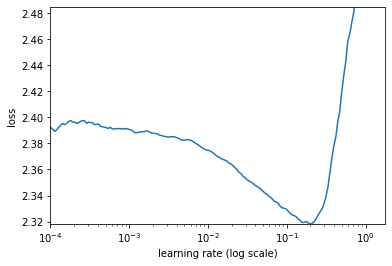

In [5]:
from lr_finder import lr_finder
import matplotlib.pyplot as plt

batch_size = 64
valid_size = 0.2
num_workers = multiprocessing.cpu_count()

transforms = get_transforms(rand_augment_magnitude=9)
data_loaders = get_data_loaders(batch_size, valid_size, transforms, num_workers)

# Range and number of steps for the learning rate
min_lr = 1e-5
max_lr = 1
n_steps = min(len(data_loaders['train']), 200)

# loss function (categorical cross-entropy)
loss = nn.CrossEntropyLoss()

losses = lr_finder(min_lr, max_lr, n_steps, loss, model, data_loaders)

# Plot the results
plt.plot(losses.keys(), losses.values())
plt.xscale("log")
plt.ylabel("loss")
plt.xlabel("learning rate (log scale)")

# Adjust the range on the y-axis to see things more clearly
plt.xlim([1e-4, None])
plt.ylim([min(losses.values()), np.percentile(list(losses.values()), 97)])

---
## Learning Rate Scheduler + Hyperparameter Optimization

The learning rate scheduler changes the learning rate as the training progresses, and the hyperparameter optimization that optimizes the choices to maximize performance.

In [6]:
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
from helpers import train_one_epoch, valid_one_epoch
import torch.optim


def optimize(data_loaders, model, optimizer, loss, n_epochs, save_path, interactive_tracking=False):
    
    # This is a plotting function
    def after_subplot(ax: plt.Axes, group_name: str, x_label: str):
        """Add title xlabel and legend to single chart"""
        ax.set_title(group_name)
        ax.set_xlabel(x_label)
        ax.legend(loc="center right")
        
    # initialize tracker for minimum validation loss
    if interactive_tracking:
        liveloss = PlotLosses(outputs=[MatplotlibPlot(after_subplot=after_subplot)])
    else:
        liveloss = None

    valid_loss_min = None
    logs = {}

    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(  
        optimizer, "min", verbose=True, threshold=0.01  
    )  

    for epoch in range(1, n_epochs + 1):

        train_loss = train_one_epoch(
            data_loaders["train"], model, optimizer, loss
        )

        valid_loss = valid_one_epoch(data_loaders["valid"], model, loss)

        # If the validation loss decreases by more than 1%, save the model
        if valid_loss_min is None or (
                (valid_loss_min - valid_loss) / valid_loss_min > 0.01
        ):

            # Save the weights to save_path
            torch.save(model.state_dict(), save_path)  

            valid_loss_min = valid_loss

        

        scheduler.step(valid_loss)  

        # Log the losses and the current learning rate
        if interactive_tracking:
            logs["loss"] = train_loss
            logs["val_loss"] = valid_loss
            logs["lr"] = optimizer.param_groups[0]["lr"]

            liveloss.update(logs)
            liveloss.send()

In [7]:
import mlflow 
from helpers import one_epoch_test

def train_one_model(learning_rate, rand_augment_magnitude, n_epochs):
    
    transforms = get_transforms(rand_augment_magnitude=rand_augment_magnitude)
    data_loaders = get_data_loaders(batch_size, valid_size, transforms, num_workers)
    model = Net()
    
    if train_on_gpu:
        model.cuda()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    loss = nn.CrossEntropyLoss()
    
    with mlflow.start_run():
        
        optimize(data_loaders, model, optimizer, loss, n_epochs, "best_val_loss.pt", interactive_tracking=True)
        
        # Restore best validation loss
        model.load_state_dict(torch.load('best_val_loss.pt'))
        
        # Test model on *validation* set 
        val_loss, preds, actuals = one_epoch_test(data_loaders['valid'], model, loss)
        
        # mlflow.log_param to log the learning rate and the rand_augment_magnitude
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("rand_augment_magnitude", rand_augment_magnitude)
        
        # mlflow.log_metric to log your validation loss
        mlflow.log_metric("val_loss", val_loss)
        
        val_accuracy = (np.array(preds)==np.array(actuals)).sum() / len(actuals)
        
        # mlflow to log the validation accuracy as a metric
        mlflow.log_metric("val_accuracy", val_accuracy)
        
        # mlflow.log_artifact to log the best_val_loss.pt file
        mlflow.log_artifact("best_val_loss.pt")

## Random Search

Using random search technique to explore our hyperparameters:

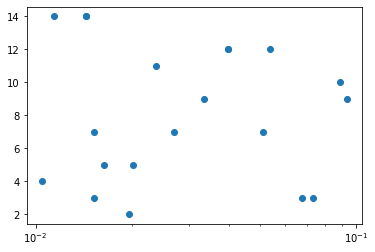

In [8]:
# Making a random grid of learning rate and rand_augment_magnitude
min_lr = 0.01
max_lr = 0.1

n_grid = 20

# Sample log-uniformly the learning rate
lrs = 10**(np.random.uniform(np.log10(min_lr), np.log10(max_lr), n_grid))
# Sample uniformly the rand augment transform strength
r_a_mag = np.random.randint(1, 15, n_grid)

# Plot our grid
_ = plt.scatter(lrs, r_a_mag)
_ = plt.xscale("log")

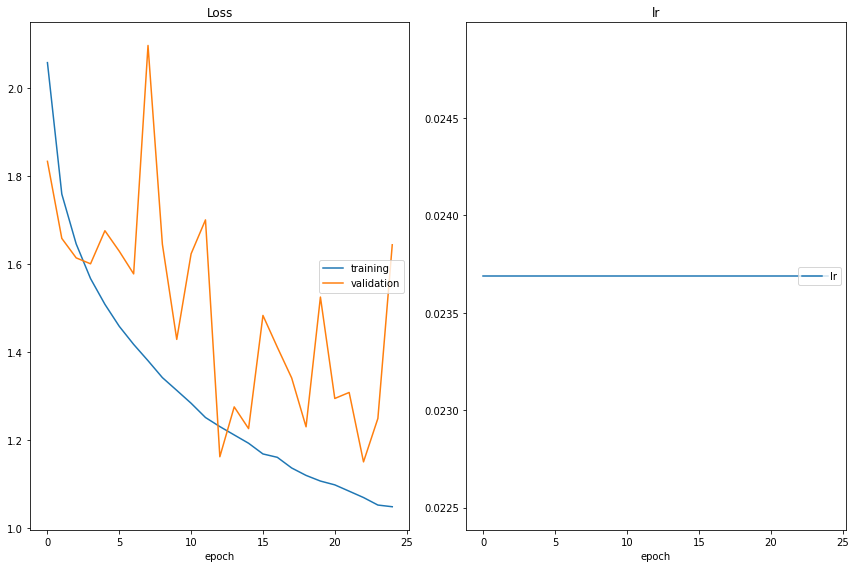

Training:  20%|██████▋                          | 16/79 [00:03<00:07,  7.90it/s]

In [ ]:
# Run our experiments
for lr, rand_aug_mag in zip(lrs, r_a_mag):
    train_one_model(lr, rand_aug_mag, n_epochs=70)

In [14]:
import mlflow

runs = mlflow.search_runs()
sorted_runs = runs[
    [
        "run_id",
        "params.learning_rate",
        "params.rand_augment_magnitude",
        "metrics.val_loss",
        "metrics.val_accuracy",
    ]
].sort_values(by='metrics.val_loss')
sorted_runs

,run_id,params.learning_rate,params.rand_augment_magnitude,metrics.val_loss,metrics.val_accuracy
8,baf835d326a94f6fb088aff08ec2b514,0.09330606024425661,9,0.609516,0.7964
18,32636625154e4e0c84b31d1f4f7e8e3e,0.08927180304353625,10,0.620304,0.7878
16,439a7abb2b414c2cb0511099cd4d3be8,0.039687933304443715,12,0.624861,0.7936
7,100fbf2efef548de801903d9b733acca,0.06798962421591127,3,0.626099,0.7869
10,91a54a89caa647aa8939d23ee955fbd8,0.051059032093947555,7,0.633003,0.7901
12,7f5a8cb9d89c4dc7b0960ad44b9bfc49,0.07348118405270446,3,0.637622,0.7876
17,5e26a722a3384c65b93841b71c3fe0bb,0.05395030966670226,12,0.641568,0.7828
1,1041a1d140f54bae87056a0eb88389b6,0.027036160666620002,7,0.644934,0.7832
2,bc856fe602714616926c4a8e32e3ee57,0.03347776308515934,9,0.651725,0.7813
11,0c0a5eb751214c9f899cde6bd8fd41b5,0.03991305878561677,12,0.654202,0.7827


In [16]:
from mlflow.tracking import MlflowClient

# Get the id with the lowest val_loss
lowest_loss_id = sorted_runs.iloc[0]['run_id']

# Fetch the best model from that run
client = MlflowClient()
local_path = client.download_artifacts(lowest_loss_id, "best_val_loss.pt", '.')


# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('best_val_loss.pt'))

<All keys matched successfully>

---
## Test the Trained Network

In [18]:
from helpers import one_epoch_test

test_loss, preds, actuals = one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|███████████████████████████████| 157/157 [00:00<00:00, 306.34it/s]

Test Loss: 0.630267


Test Accuracy: 78% (7847/10000)


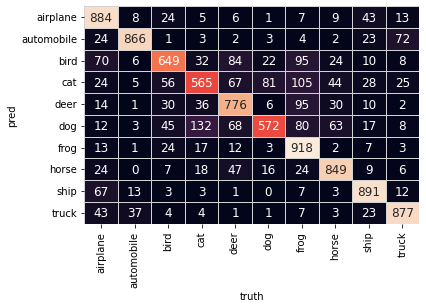

In [19]:
from helpers import plot_confusion_matrix

cm = plot_confusion_matrix(preds, actuals, classes)